In [1]:
import skimage.io as skio
import skimage
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import numpy as np
from bench_filter import Bench_Filter
from sklearn.model_selection import train_test_split
import random
import skimage.morphology as skm
from tools import *

In [2]:
from multiprocessing import cpu_count
cpus = cpu_count()
print(f'Number of CPU cores available : {cpus}')

Number of CPU cores available : 4


In [3]:
DATASET = ['Fluo-N2DL-HeLa','PhC-C2DH-U373']
idx = 1

IM_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TRAIN/*.tif'))
TG_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TRAIN/*.tif'))

In [4]:
X_train, y_train = load_img_tg(IM_PATH, TG_PATH)
X_train = X_train[0:int(len(X_train)/8)]
y_train = y_train[0:int(len(y_train)/8)]
len(X_train)

23

In [5]:
X_train_cropped, y_train_cropped = crop_img_tg(X_train,y_train,4)

Initial dimensions of images : (520,696)
Patch dimensions : (130,174)


In [6]:
BF = Bench_Filter(n_estimators=18, cpus=cpus-1) #Leave 1 cpu to avoid computer crash
nb_orientations = 8
radians = np.linspace(0, 2*np.pi*(1-1/nb_orientations), nb_orientations)
frequency = [0.1]
for freq in frequency :
    for rad in radians :
        BF.add_gabor(freq,rad)
BF.add_stddev(3)
BF.add_stddev(5)
BF.add_stddev(8)
BF.add_gaussian(np.sqrt(2)*2)
BF.add_median(skm.disk(3))
BF.add_sobel()
BF.add_farid()
BF.add_prewitt()
BF.add_roberts()
BF.add_scharr()

In [7]:
BF.fit(X_train_cropped, y_train_cropped)

Applying filters to dataset: 23it [00:49,  2.15s/it]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 18
building tree 2 of 18
building tree 3 of 18
building tree 4 of 18
building tree 5 of 18
building tree 6 of 18
building tree 7 of 18
building tree 8 of 18
building tree 9 of 18
building tree 10 of 18
building tree 11 of 18
building tree 12 of 18
building tree 13 of 18
building tree 14 of 18
building tree 15 of 18
building tree 16 of 18
building tree 17 of 18
building tree 18 of 18


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   16.9s finished


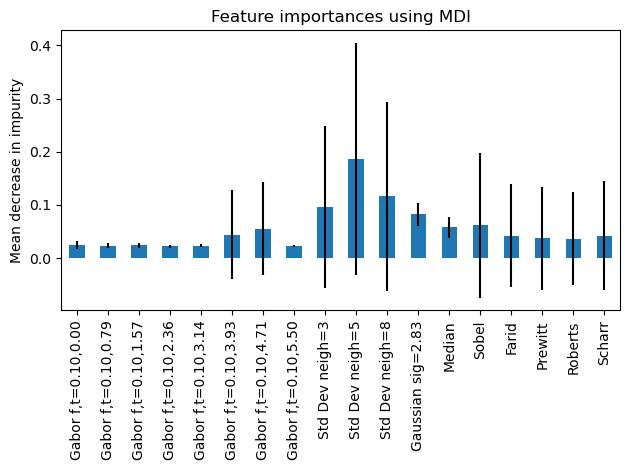

In [8]:
RF_feature_importances(BF)

In [9]:
IM_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TEST/*.tif'))
TG_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TEST/*.tif'))

X_test, y_test = load_img_tg(IM_TEST_PATH, TG_TEST_PATH)

In [10]:
y_pred = BF.predict(X_test[0:5])

Applying filters to dataset: 5it [02:35, 31.03s/it]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    1.8s finished


Text(0, 0.5, 'Frequency')

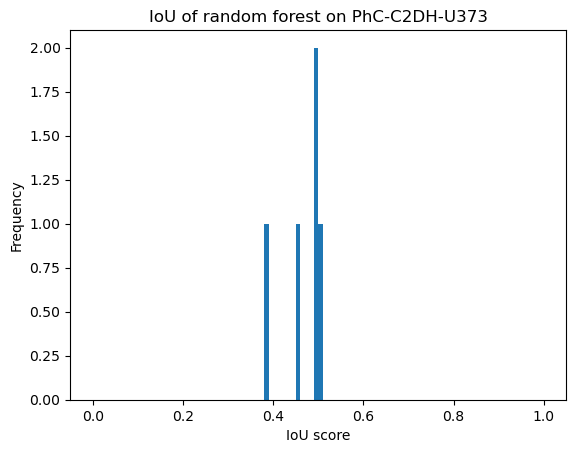

In [11]:
results = []
for i, pred in enumerate(y_pred):
    results.append(jaccard_score(y_test[i],pred,average='micro'))
plt.hist(results,bins=100,range=(0,1))
plt.title(f'IoU of random forest on {DATASET[idx]}')
plt.xlabel('IoU score')
plt.ylabel('Frequency')
#plt.savefig(f'output/Custom_RF/rf_crop_performance_dataset_{idx}.png')

Applying filters to dataset: 1it [00:28, 28.44s/it]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    0.3s finished


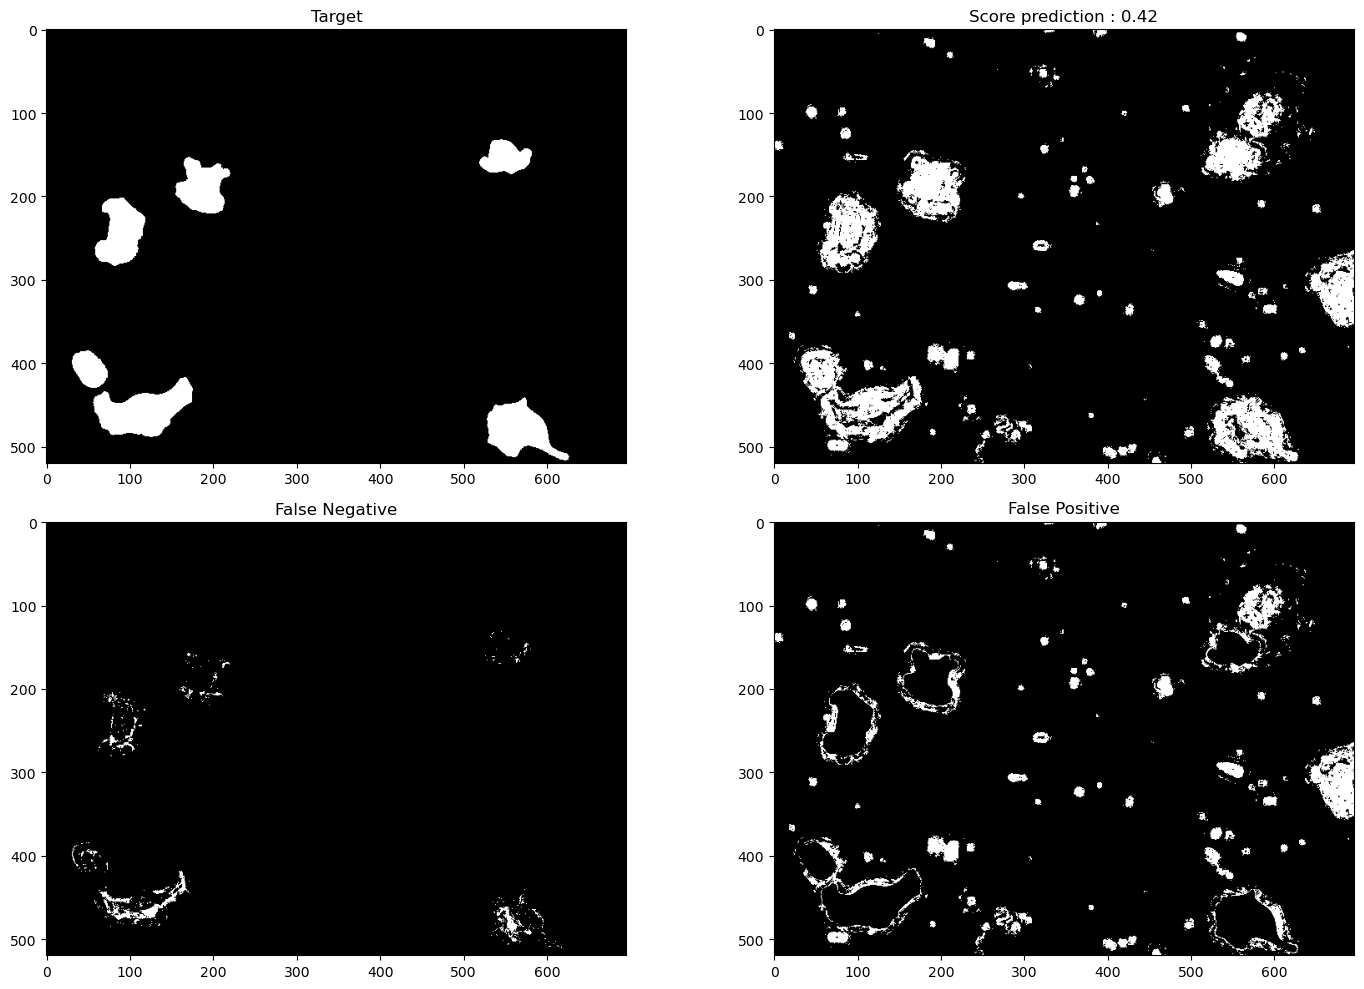

In [17]:
n_im = random.randrange(len(y_test))
target = y_test[n_im]
seg = skimage.img_as_bool(BF.predict([X_test[n_im]])[0])
score = jaccard_score(target,seg,average='micro')

fig = plot_pred_with_target(target,seg,score)
fig.savefig(f'output/Custom_RF/inference_rf_crop_dataset_{idx}.png')

Applying filters to dataset: 1it [00:00,  3.19it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished
Applying filters to dataset: 1it [00:00,  3.17it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished
Applying filters to dataset: 1it [00:00,  3.20it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished
Applying filters to dataset: 1it [00:00,  2.69it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: 

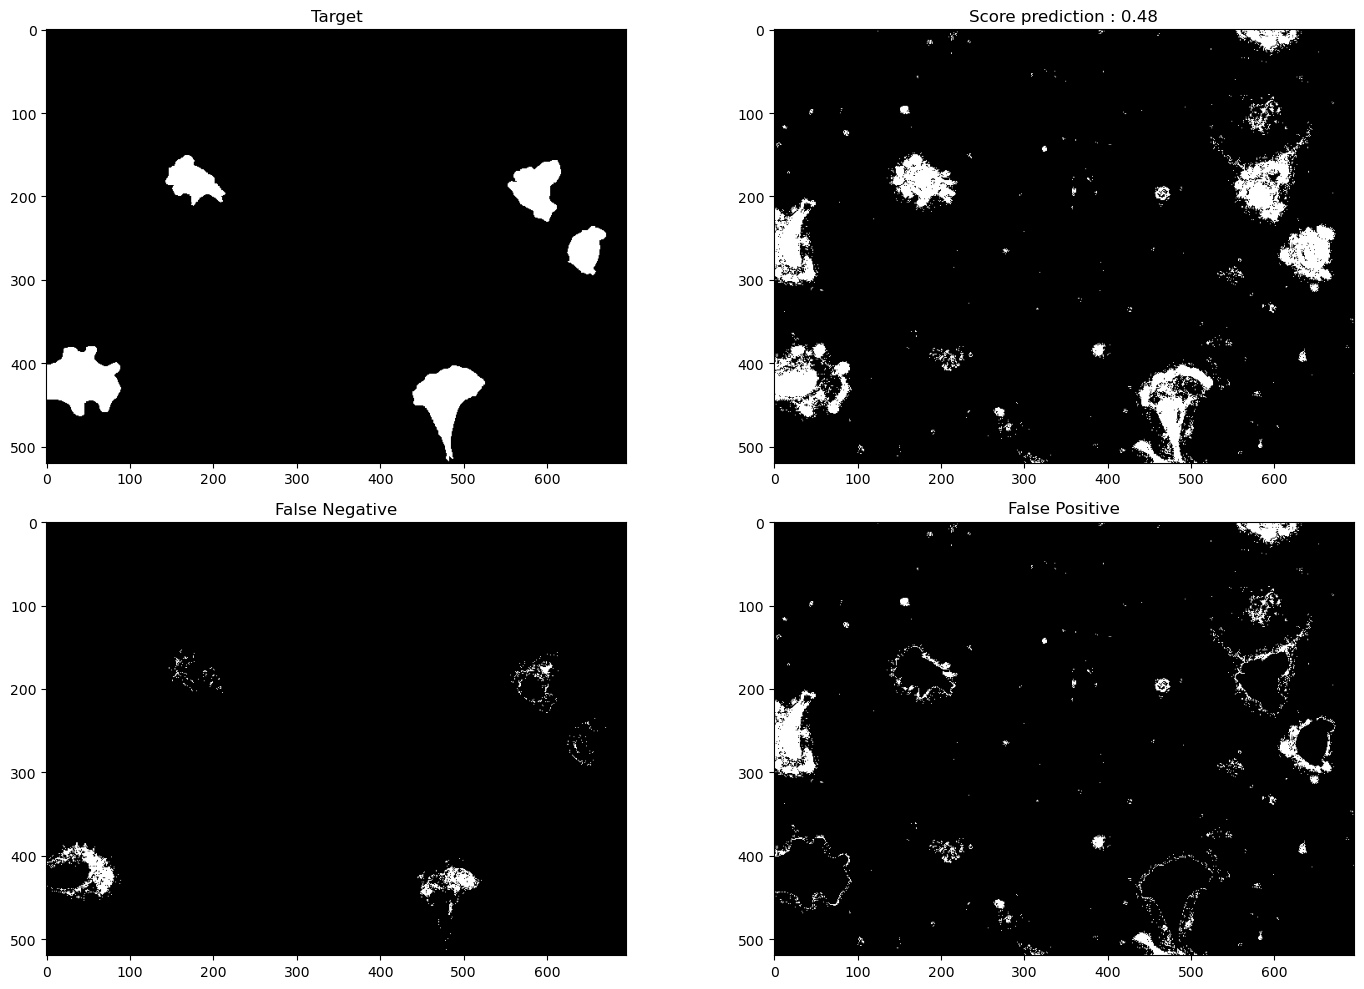

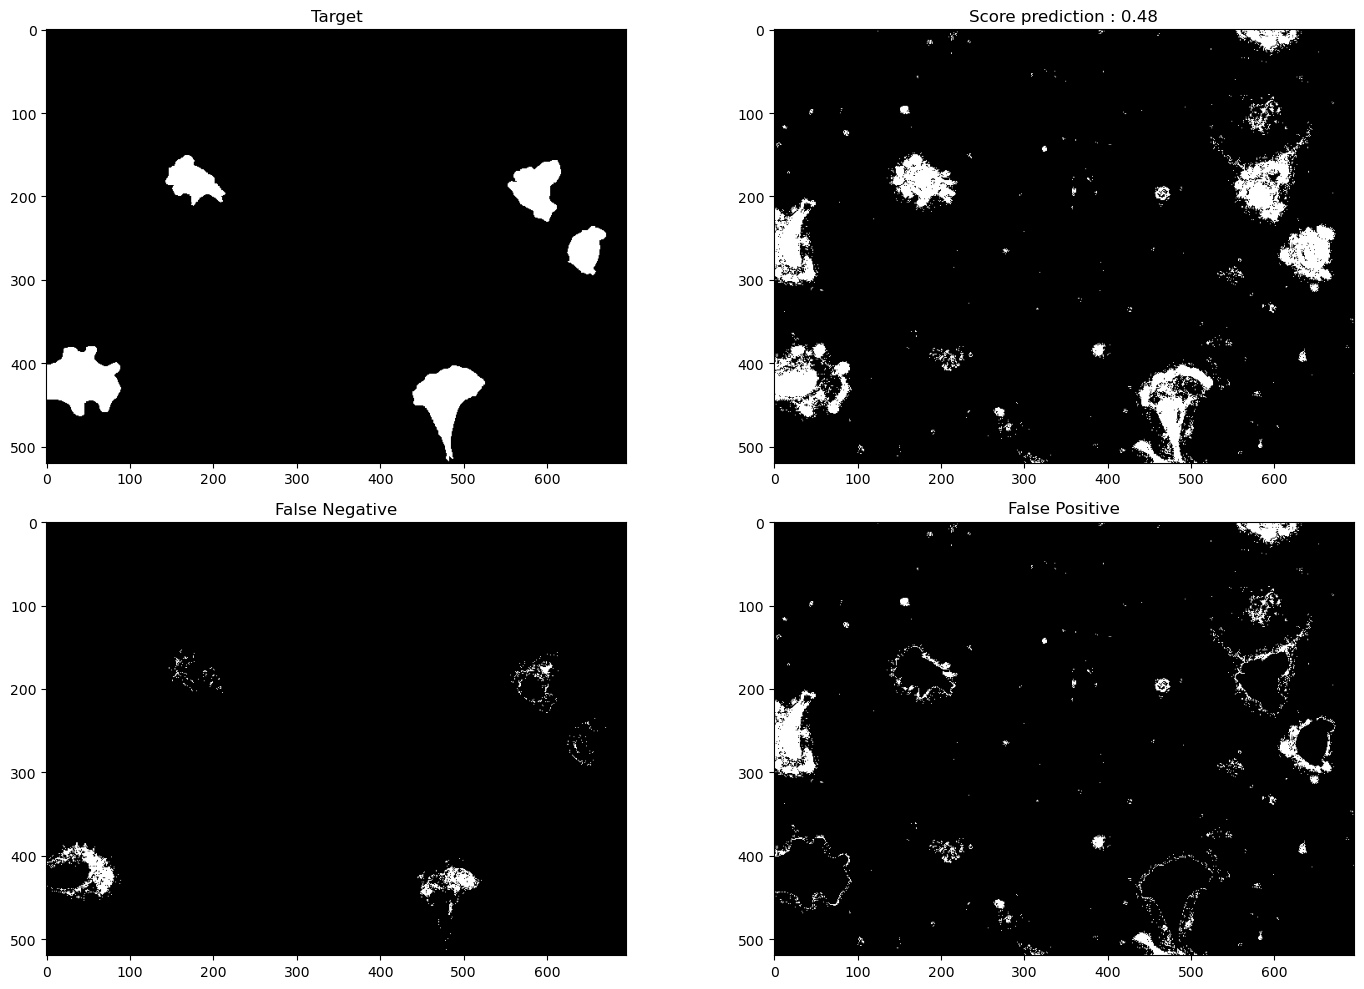

In [14]:
score = 1
n_im = 0
while score > 0.5 and n_im < len(y_test) :
    target = y_test[n_im]
    seg = skimage.img_as_bool(BF.predict([X_test[n_im]])[0])
    score = jaccard_score(target,seg,average='micro')
    n_im += 1
    
plot_pred_with_target(target,seg,score)
    